<a href="https://colab.research.google.com/github/Serafina-Z/opinion-analysis/blob/main/politics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Politics Opinion Analysis**

**Data Loading**

In [ ]:
from google.colab import files
uploaded = files.upload() # upload kaggle.json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download aashita/nyt-comments -f CommentsApril2017.csv -p /content/

In [7]:
from zipfile import ZipFile
with ZipFile("CommentsApril2017.csv.zip", 'r') as zip:
  zip.extractall()

In [ ]:
import pandas as pd
from collections import Counter
data = pd.read_csv("/content/CommentsApril2017.csv")

In [ ]:
!pip install pandasql
from pandasql import sqldf
q1 = """
         select sectionName, articleID, commentBody, editorsSelection, recommendations
         from data
         where (sectionName = 'Politics')
"""

In [10]:
pysqldf = lambda q: sqldf(q, globals())
clean = pysqldf(q1)

In [11]:
clean.shape

(38381, 5)

In [12]:
len(Counter(clean["articleID"]).keys())

51

**Text Cleaning**

In [ ]:
!pip install nltk
import nltk
nltk.download("all")
from nltk import sent_tokenize
sentences = [] # each comment as a doc
for i in clean["commentBody"]:
    s=sent_tokenize(i)
    sentences.append(s)
sentences[0]

In [14]:
# tokenization
from nltk.tokenize import word_tokenize
token_list= []
for i in sentences: # i is comment level
    for j in i:
      tokens = word_tokenize(j)
      words = [word for word in tokens if word.isalpha()]
      words = [word.lower() for word in words]
      token_list.append(words)

In [15]:
# lemmatization
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet 
lemmatizer = WordNetLemmatizer() 
def pos_tagger(nltk_tag): 
    if nltk_tag.startswith('J'): 
        return wordnet.ADJ 
    elif nltk_tag.startswith('V'): 
        return wordnet.VERB 
    elif nltk_tag.startswith('N'): 
        return wordnet.NOUN 
    elif nltk_tag.startswith('R'): 
        return wordnet.ADV 
    else:           
        return None
lemma_list = []
for i in token_list:
  pos_tagged = nltk.pos_tag(i)
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
  lemma = [] 
  for word, tag in wordnet_tagged:
    if word == "i":
      continue
    if tag is None: 
      # if there is no available tag, append the token as is 
      lemma.append(word) 
    else:         
      # else use the tag to lemmatize the token 
      lemma.append(lemmatizer.lemmatize(word, tag))
  lemma_list.append(lemma)

**Aspect Extraction**

In [16]:
bi = []
for item in lemma_list:
  grams = [item[i:i+2] for i in range(len(item)-2+1)]
  bigrams = [' '.join(j) for j in grams]
  bi.append(bigrams)

In [17]:
bi_v = [bigram for i in bi for bigram in i]
uni_v = [unigram for i in lemma_list for unigram in i]

In [18]:
counter_bi = Counter(bi_v)

In [19]:
from nltk.corpus import stopwords

In [20]:
# filter before computing for less noise
for i in list(counter_bi.keys()):
  if i.split()[0] in stopwords.words('english'):
    if i.split()[1] in stopwords.words('english'):
      counter_bi.pop(i)

In [21]:
for i in list(counter_bi.keys()):
  w,t = nltk.pos_tag(i.split())[0]
  w1,t1 = nltk.pos_tag(i.split())[1]
  if t[0] != "N":
    if t1[0] != "N":
      counter_bi.pop(i)

In [22]:
import math
def pmi_index(bigram):
  a, b = bigram.split()
  new = []
  for i in bi_v:
    if i != bigram:
      for wor in i.split():
        new.append(wor)
    else:
      new.append(i)
  counter_new = Counter(new)
  if counter_new[a] == 0 or counter_new[b] == 0:
    pmi = "dependent"
  else:
    pmi = math.log(counter_new[bigram]/((counter_new[a]-counter_new[bigram])*(counter_new[b]-counter_new[bigram])/(len(new)-2*counter_new[bigram])))
  return pmi

In [23]:
counter_b = counter_bi.most_common(100)

In [24]:
bi_gram_list = [k for (k,v) in counter_b]

In [25]:
frequency = [v for (k,v) in counter_b]

In [26]:
pmi = [pmi_index(k) for (k,v) in counter_b]

In [27]:
fre_df = pd.DataFrame({"bigram":bi_gram_list, "pmi":pmi, "frequency": frequency})

In [28]:
fre_most = fre_df.sort_values(by="pmi", ascending=False).head(50)
fre_most

,bigram,pmi,frequency
28,http http,13.819215,825
9,supreme court,10.099670,1375
75,north korea,9.686748,495
3,white house,8.356377,1577
49,middle class,8.092947,655
45,united state,7.350041,666
21,health care,6.678027,1047
23,tax return,5.556808,974
71,tax reform,5.533427,509
25,donald trump,5.033974,905


In [29]:
select = fre_most.drop([28,86,63,62,40,29,34,31,66,7,89,95,50,59,48,93,33,64,11,2,20,54,1,41,33,18,81,37,85])
select_bi = select["bigram"] # 22 bigrams selected

In [30]:
len(select_bi)

22

In [31]:
from collections import defaultdict  
bi_dict = defaultdict(list)
for bi in select_bi:
  f,s = bi.split()
  bi_dict[f].append(s)

In [33]:
sent_c = []
for sent in lemma_list: 
  if len(sent) > 1:
    sent_list = []
    for i in range(len(sent)-1):
      if sent[i] in list(bi_dict.keys()):
        if sent[i+1] in bi_dict[sent[i]]:
          bi = sent[i] + " " + sent[i+1]
          sent_list.append(bi)
        else:
          if sent[i] not in stopwords.words('english'):
            sent_list.append(sent[i])  
      else:
        if sent[i] not in stopwords.words('english'):
          sent_list.append(sent[i]) 
    sent_c.append(sent_list)
  elif len(sent) == 1:
    if sent[0] not in stopwords.words('english'):
      sent_c.append(sent)
    else:
      sent_c.append([])
  else:
    sent_c.append([])

In [39]:
sent1 = [] # comment level
for c in sentences:
  ll = []
  for s in c:
    tokens = word_tokenize(s)
    words = [word for word in tokens if word.isalpha()]
    words = [word.lower() for word in words]
    words = [word for word in words if word != 'i']
    ll.append(words)
  sent1.append(ll)

In [40]:
num_com = len(sentences)

In [41]:
com_sent = [] # basic list is sentence
count = 0
for i in range(num_com):
  end = count + len(sent1[i])
  cc = sent_c[count:end]
  com_sent.append(cc)
  count = end

In [42]:
comment = [] # basic list is comment
for com in com_sent:
  c = []
  for sent in com:
    for wor in sent:
      c.append(wor)
  comment.append(c)

In [43]:
noun = []
for com in comment:
  c = []
  for wor in com:
    if wor in select_bi:
      c.append(wor)
    else:
      w, t = nltk.pos_tag([wor])[0]
      if t[0] == "N":
        c.append(wor)
  noun.append(c)

In [44]:
words = [wor for c in noun for wor in c]

In [45]:
v_n = [n for n,c in Counter(words).most_common(500)]

In [46]:
!pip install sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
df = pd.DataFrame({"text":comment})
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x]))
vectorizer = TfidfVectorizer(vocabulary=v_n, ngram_range=(1,2))
TF_IDF = vectorizer.fit_transform(df['text'].values)
TF_IDF_array = TF_IDF.toarray()

In [47]:
import numpy as np
sum = np.sum(TF_IDF_array,axis=0).tolist()

In [48]:
rank = pd.DataFrame({"feature":vectorizer.get_feature_names(),"index": sum}).sort_values("index", ascending=False)
rank.head(20)

,feature,index
0,trump,2434.014595
2,tax,1309.863682
1,people,1053.633991
3,president,890.851764
4,think,865.854719
11,obama,742.783272
5,time,732.073513
7,need,727.464272
28,house,710.082666
9,democrat,685.242863


In [49]:
aspects = rank.head(20)["feature"]

**Aspect Categorization**

In [34]:
!pip install gensim
import gensim

In [35]:
from gensim.models import Word2Vec

In [36]:
www = [word for item in sent_c for word in item]

In [37]:
len(Counter(www).keys())

28101

In [38]:
def skip(sent, n=3, s=2):
  k_grams = []
  for i in range(len(sent)):
    for z in range(s):
      seq = [sent[i]] + sent[i+z+1:i+z+n]
      if len(seq) == n and seq not in k_grams:
        k_grams.append(list(seq))
  return k_grams  

In [50]:
sent_c1 = [sent for sent in sent_c if sent != []]

In [51]:
sequences = []
for i in sent_c1:
  l = skip(i)
  sequences.append(l)

In [52]:
sequences = [sent for sent in sequences if sent != []]
seq = [s for sent in sequences for s in sent]

In [53]:
seq[:10]

[['chuck', 'schumer', 'really'],
 ['chuck', 'really', 'ca'],
 ['schumer', 'really', 'ca'],
 ['schumer', 'ca', 'gorsuch'],
 ['really', 'ca', 'gorsuch'],
 ['really', 'gorsuch', 'declare'],
 ['ca', 'gorsuch', 'declare'],
 ['ca', 'declare', 'gorsuch'],
 ['gorsuch', 'declare', 'gorsuch'],
 ['gorsuch', 'gorsuch', 'unacceptable']]

In [ ]:
model = Word2Vec(seq, min_count=50)

In [ ]:
word = 'trump'
model1.wv.most_similar(positive=word)[:5]

[('donald', 0.5976710915565491),
 ('dt', 0.5490655899047852),
 ('djt', 0.5415180921554565),
 ('donnie', 0.5342236757278442),
 ('untrustworthy', 0.49982917308807373)]

In [ ]:
aspect_c = defaultdict(list)
for i in aspects:
  similar = model1.wv.most_similar(positive=i)[:5]
  for w, s in similar:
    aspect_c[i].append(w)

In [ ]:
aspect_c

defaultdict(list,
            {'care': ['healthcare',
              'comprehensive',
              'accessible',
              'health care',
              'affordable'],
             'country': ['nation', 'usa', 'planet', 'us', 'america'],
             'court': ['scotus', 'sc', 'supreme court', 'bench', 'overturn'],
             'cut': ['slash',
              'reduction',
              'giveaway',
              'discretionary',
              'cutting'],
             'democrat': ['dems',
              'democrats',
              'dem',
              'republican',
              'legislator'],
             'gop': ['republican', 'the gop', 'republicans', 'dems', 'dem'],
             'house': ['visitor', 'occupant', 'wh', 'emanate', 'whitewater'],
             'need': ['must', 'unless', 'want', 'necessary', 'suppose'],
             'obama': ['gall',
              'president obama',
              'obamas',
              'predecessor',
              'previous'],
             'pay': ['rebate',

In [54]:
aspect_c = {'care': ['healthcare', 'comprehensive', 'accessible', 'health care', 'affordable'], 'country': ['nation', 'usa', 'planet', 'us', 'america'], 'court': ['scotus', 'sc', 'supreme court', 'bench', 'overturn'], 'cut': ['slash', 'reduction', 'giveaway', 'discretionary','cutting'], 'democrat': ['dems', 'democrats', 'dem', 'republican', 'legislator'], 'gop': ['republican', 'the gop', 'republicans'], 'house': ['visitor', 'occupant', 'wh', 'emanate', 'whitewater'], 'need': ['must', 'unless', 'want', 'necessary', 'suppose'], 'obama': ['gall', 'president obama', 'obamas', 'predecessor', 'previous'], 'pay': ['rebate', 'paid', 'reimburse', 'payroll', 'earned'], 'people': ['folk', 'constituent', 'illegals', 'person', 'americans'], 'president': ['potus', 'presidential', 'duly', 'presidency', 'occupant'], 'state': ['governor', 'assistant', 'county', 'herring', 'commerce'], 'tax': ['amt', 'income tax', 'simplify', 'monies', 'loophole'], 'think': ['believe', 'afraid', 'funny', 'conceive', 'imagine'], 'time': ['ink', 'month', 'occasion', 'nytimes', 'yr'], 'trump': ['donald', 'dt', 'djt', 'donnie', 'untrustworthy'], 'vote': ['reelect', 'runoff', 'slim', 'stein', 'ballot'], 'want': ['need', 'cant', 'meantime', 'besides', 'pledge'], 'world': ['region', 'the world', 'beacon', 'eu', 'unfold']}

In [55]:
d = ['cut', 'need', 'pay', 'time', 'want', 'think']
for i in d:
  aspect_c.pop(i)
category = dict(aspect_c)

In [56]:
for (a, s) in category.items():
  for wor in s:
    w,t = nltk.pos_tag([wor])[0]
    if t[0] != 'N':
      category[a].remove(wor)

In [57]:
category

{'care': ['healthcare', 'comprehensive', 'health care'],
 'country': ['nation', 'usa', 'planet', 'america'],
 'court': ['scotus', 'sc', 'supreme court', 'bench', 'overturn'],
 'democrat': ['dems', 'democrats', 'dem', 'legislator'],
 'gop': ['the gop', 'republicans'],
 'house': ['visitor', 'occupant', 'wh', 'emanate', 'whitewater'],
 'obama': ['gall', 'president obama', 'obamas', 'predecessor'],
 'people': ['folk', 'constituent', 'illegals', 'person', 'americans'],
 'president': ['potus', 'duly', 'presidency', 'occupant'],
 'state': ['governor', 'assistant', 'county', 'commerce'],
 'tax': ['amt', 'income tax', 'simplify', 'monies', 'loophole'],
 'trump': ['donald', 'dt', 'djt', 'donnie'],
 'vote': ['reelect', 'runoff', 'slim', 'stein', 'ballot'],
 'world': ['region', 'the world', 'beacon', 'eu']}

In [58]:
for k in category.keys():
  category[k].append(k)

In [59]:
opinion_d = []
for com in com_sent:
  com_d = defaultdict(list)
  for s in com:
    for k in category.keys():
      if any(w in s for w in category[k]) is True:
        com_d[k].append(s)
  opinion_d.append(dict(com_d))

In [60]:
opinion = pd.DataFrame({"opinion sentences": opinion_d, "recommendation": clean["recommendations"], "editor selection": clean["editorsSelection"]})

In [61]:
opinion.drop(opinion[opinion['opinion sentences'] == {}].index, inplace = True)

**Sentiment Orientation**

In [62]:
def split_sentence(o_p, k):
  if k in o_p.keys():
    list_s = o_p[k]
  else:
    list_s = []
  return list_s

In [63]:
for k in category.keys():
  m = []
  for i in opinion['opinion sentences']:
    x = split_sentence(i, k)
    m.append(x)
  opinion[k] = m

In [64]:
# care
care = pd.DataFrame({"care": opinion['care']})
care = care[care['care'].apply(lambda x: len(x)) > 0]
care_index = list(care.index)

In [65]:
care_list = []
for i in list(care["care"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  care_list.append(w)
v1 = [w for s in care_list for w in s]
feature1 = Counter(v1).keys()
care_list = pd.DataFrame({"care":care_list})
care_list['care'] = care_list['care'].apply(lambda x: ' '.join([word for word in x]))

In [66]:
vectorizer = TfidfVectorizer(vocabulary=feature1, ngram_range=(1,2))
TF_IDF1 = vectorizer.fit_transform(care_list['care'].values)
TF_IDF_array1 = TF_IDF1.toarray()

In [67]:
from sklearn.cluster import KMeans
kmeans1 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF1)

In [68]:
from sklearn.metrics import pairwise_distances_argmin_min
closest1, _ = pairwise_distances_argmin_min(kmeans1.cluster_centers_, TF_IDF1)

In [69]:
sentences[care_index[closest1[0]]]  # negative

['A single-payer health care system?',
 'After the car (current one) breaks down?',
 'Dream on.',
 'This Republican government will provide an ambulance at the bottom of the cliff.',
 'Oh, cancel that.',
 'A hearse.']

In [70]:
sentences[care_index[closest1[1]]]  # positive

["Democrats chose to make Trump's tax returns central to their 2016 election campaign (as opposed to immigration, jobs, national security and healthcare.)",
 'It was a strategy that failed.',
 'Now it is time to help govern.',
 'Offer votes in return for concessions on Estate taxes, AMT, or whatever.',
 "Don't insist on a strategy that failed last year.",
 "I don't care about Trump's taxes.",
 'I do care about my own.']

In [71]:
label1 = kmeans1.labels_

In [ ]:
opinion["senti1"] = np.zeros(len(opinion))
for i in range(len(label1)):
  if label1[i] == 0:
    opinion["senti1"][care_index[i]] = -1
  if label1[i] == 1:
    opinion["senti1"][care_index[i]] = 1

In [73]:
# country
country = pd.DataFrame({"country": opinion['country']})
country = country[country['country'].apply(lambda x: len(x)) > 0]
country_index = list(country.index)

In [74]:
country_list = []
for i in list(country["country"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  country_list.append(w)
v2 = [w for s in country_list for w in s]
feature2 = Counter(v2).keys()
country_list = pd.DataFrame({"care":country_list})
country_list['country'] = country_list['care'].apply(lambda x: ' '.join([word for word in x]))

In [75]:
vectorizer2 = TfidfVectorizer(vocabulary=feature2, ngram_range=(1,2))
TF_IDF2 = vectorizer2.fit_transform(country_list['country'].values)
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF2)
closest2, _ = pairwise_distances_argmin_min(kmeans2.cluster_centers_, TF_IDF2)

In [76]:
sentences[country_index[closest2[0]]] # negative

["We the people need to have a say in the self-imposed 'rules' that are on display in the house and senate.",
 'They are doing the country a disservice-']

In [77]:
sentences[country_index[closest2[1]]] # positive

["America's own Article 48."]

In [ ]:
label2 = kmeans2.labels_
opinion["senti2"] = np.zeros(len(opinion))
for i in range(len(label2)):
  if label2[i] == 0:
    opinion["senti2"][country_index[i]] = -1
  if label2[i] == 1:
    opinion["senti2"][country_index[i]] = 1

In [79]:
# court
court = pd.DataFrame({"court": opinion['court']})
court = court[court['court'].apply(lambda x: len(x)) > 0]
court_index = list(court.index)

In [80]:
court_list = []
for i in list(court["court"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  court_list.append(w)
v3 = [w for s in court_list for w in s]
feature3 = Counter(v3).keys()
court_list = pd.DataFrame({"court":court_list})
court_list['court'] = court_list['court'].apply(lambda x: ' '.join([word for word in x]))

In [81]:
vectorizer3 = TfidfVectorizer(vocabulary=feature3, ngram_range=(1,2))
TF_IDF3 = vectorizer3.fit_transform(court_list['court'].values)
kmeans3 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF3)
closest3, _ = pairwise_distances_argmin_min(kmeans3.cluster_centers_, TF_IDF3)

In [82]:
sentences[court_index[closest3[0]]] # negative

["The democrats didn't change the rules for the filibuster of the Supreme Court is because there was no Supreme Court nominee at the time.",
 'The democrats got rid of the filibuster rules in 2013.',
 'They just left a few tattered ends.<br/>But the nation is taking notice.',
 'The streets are filled with citizens protesting the end of the filibuster!',
 'Oh wait.....that is just the ball game letting out.']

In [83]:
sentences[court_index[closest3[1]]] # positive

['The GOP, whose policies are bankrupt for the vast middle class, has to cheat (gerrymander, pass bogus voting restrictions, etc.)',
 'and lie to push through whatever their corporate lords have paid them to do.',
 'These same are Gorsuch supporters, and have paid for commercials in support of his candidacy.',
 '(For a Supreme Court seat?',
 'Whoever heard of such a thing?)',
 '<br/><br/>McConnell failed to do his Constitutional duty by refusing to "advise and<br/>consent" to Merrick Garland, or even to give him a hearing.',
 'Now, he is threatening to change the rules of the Senate to seat this candidate.',
 '<br/><br/>At what point, in this country, will there be consequences for breaking its rules?']

In [ ]:
label3 = kmeans3.labels_
opinion["senti3"] = np.zeros(len(opinion))
for i in range(len(label3)):
  if label3[i] == 0:
    opinion["senti3"][court_index[i]] = -1
  if label3[i] == 1:
    opinion["senti3"][court_index[i]] = 1

In [85]:
# democrat
democrat = pd.DataFrame({"democrat": opinion['democrat']})
democrat = democrat[democrat['democrat'].apply(lambda x: len(x)) > 0]
democrat_index = list(democrat.index)

In [86]:
democrat_list = []
for i in list(democrat["democrat"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  democrat_list.append(w)
v4 = [w for s in democrat_list for w in s]
feature4 = Counter(v4).keys()
democrat_list = pd.DataFrame({"democrat":democrat_list})
democrat_list['democrat'] = democrat_list['democrat'].apply(lambda x: ' '.join([word for word in x]))

In [87]:
vectorizer4 = TfidfVectorizer(vocabulary=feature4, ngram_range=(1,2))
TF_IDF4 = vectorizer4.fit_transform(democrat_list['democrat'].values)
kmeans4 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF4)
closest4, _ = pairwise_distances_argmin_min(kmeans4.cluster_centers_, TF_IDF4)

In [88]:
sentences[democrat_index[closest4[0]]] # positive

['And the Democrats win!',
 'Tell them about their prize, Don Pardo, go ahead, tell them what they, um, won.',
 'Don.',
 'Don?',
 'Go ahead, tell them what they won.',
 'They won something, right?',
 "Didn't they?",
 'I mean, they win, right?']

In [89]:
sentences[democrat_index[closest4[1]]] # negative

['Is the filibuster only reserved for Republicans, who only need 50 seats in the senate and a Republican president to appoint Supreme Court justices?',
 'Do the Democrats need to control 60 seats in the senate and the presidency to appoint Supreme Court justices?',
 'If the answer to these questions is no, then this filibuster makes perfect sense.<br/><br/>And this is even without considering the outrageous Garland treatment and the tainted 2016 elections.']

In [ ]:
label4 = kmeans4.labels_
opinion["senti4"] = np.zeros(len(opinion))
for i in range(len(label4)):
  if label4[i] == 0:
    opinion["senti4"][democrat_index[i]] = 1
  if label4[i] == 1:
    opinion["senti4"][democrat_index[i]] = -1

In [91]:
# gop
gop = pd.DataFrame({"gop": opinion['gop']})
gop = gop[gop['gop'].apply(lambda x: len(x)) > 0]
gop_index = list(gop.index)

In [92]:
gop_list = []
for i in list(gop["gop"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  gop_list.append(w)
v5 = [w for s in gop_list for w in s]
feature5 = Counter(v5).keys()
gop_list = pd.DataFrame({"gop":gop_list})
gop_list['gop'] = gop_list['gop'].apply(lambda x: ' '.join([word for word in x]))

In [93]:
vectorizer5 = TfidfVectorizer(vocabulary=feature5, ngram_range=(1,2))
TF_IDF5 = vectorizer5.fit_transform(gop_list['gop'].values)
kmeans5 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF5)
closest5, _ = pairwise_distances_argmin_min(kmeans5.cluster_centers_, TF_IDF5)

In [94]:
sentences[gop_index[closest5[0]]] # positive

['The"wall " has always been a idiotic idea.',
 'Can anyone think of a better way to spend twenty something billion dollars?',
 'I thought so.',
 'Now, ignore the guy in the WH with nothing on and govern with the Country being the beneficiary.',
 'This experiment should have been over by now.',
 'Does the GOP have a soul?',
 'Do they sell ice in hell?',
 'It sure is getting HOT in here.']

In [95]:
sentences[gop_index[closest5[1]]] # negative

['This is how Republicans govern.',
 'They cheat, lie, and rig.',
 'With the help of Russia and that idiot Comey, Trump squeaked in and the U.S. is now firmly in the hands of corporations, the 1%, and religious fanatics.',
 'This is going to crush many if not most Republicans as well as Democrats.',
 "In my own state, the Trump counties, which is all but the two most populous, are going to be crushed by Trump's budget cuts.",
 'They got what they voted for.']

In [ ]:
label5 = kmeans5.labels_
opinion["senti5"] = np.zeros(len(opinion))
for i in range(len(label5)):
  if label5[i] == 0:
    opinion["senti5"][gop_index[i]] = 1
  if label5[i] == 1:
    opinion["senti5"][gop_index[i]] = -1

In [97]:
# house
house = pd.DataFrame({"house": opinion['house']})
house = house[house['house'].apply(lambda x: len(x)) > 0]
house_index = list(house.index)

In [98]:
house_list = []
for i in list(house["house"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  house_list.append(w)
v6 = [w for s in house_list for w in s]
feature6 = Counter(v6).keys()
house_list = pd.DataFrame({"house":house_list})
house_list['house'] = house_list['house'].apply(lambda x: ' '.join([word for word in x]))

In [99]:
vectorizer6 = TfidfVectorizer(vocabulary=feature6, ngram_range=(1,2))
TF_IDF6 = vectorizer6.fit_transform(house_list['house'].values)
kmeans6 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF6)
closest6, _ = pairwise_distances_argmin_min(kmeans6.cluster_centers_, TF_IDF6)

In [100]:
sentences[house_index[closest6[0]]] # positive

['"...Republicans in the House, Senate and White House were not on the same page.',
 '"<br/><br/>Why I\'m shocked...shocked I say...']

In [101]:
sentences[house_index[closest6[1]]] # negative

['This is an anti-intellectual, anti-fact White House and it is appalling.',
 'It is incredible that Trump has not be arrested for his many transgressions.',
 'This White House is despicable.',
 "The Republicans are despicable that they haven't reeled in Trump.",
 'I am just horrified and every single Republican legislator that has not taken a stand against Trump is despicable as well.',
 'They all are a bunch of goons.',
 'Trump needs to resign be impeached immediately, like right now.']

In [ ]:
label6 = kmeans6.labels_
opinion["senti6"] = np.zeros(len(opinion))
for i in range(len(label6)):
  if label6[i] == 0:
    opinion["senti6"][house_index[i]] = 1
  if label6[i] == 1:
    opinion["senti6"][house_index[i]] = -1

In [103]:
# obama
obama = pd.DataFrame({"obama": opinion['obama']})
obama = obama[obama['obama'].apply(lambda x: len(x)) > 0]
obama_index = list(obama.index)

In [104]:
obama_list = []
for i in list(obama["obama"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  obama_list.append(w)
v7 = [w for s in obama_list for w in s]
feature7 = Counter(v7).keys()
obama_list = pd.DataFrame({"obama":obama_list})
obama_list['obama'] = obama_list['obama'].apply(lambda x: ' '.join([word for word in x]))

In [105]:
vectorizer7 = TfidfVectorizer(vocabulary=feature7, ngram_range=(1,2))
TF_IDF7 = vectorizer7.fit_transform(obama_list['obama'].values)
kmeans7 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF7)
closest7, _ = pairwise_distances_argmin_min(kmeans7.cluster_centers_, TF_IDF7)

In [106]:
sentences[obama_index[closest7[0]]] # negative

['President Obama was Black']

In [107]:
sentences[obama_index[closest7[1]]] # positive

['Bannon has been ousted--rumor says he threatened to quit and Trump stupidly talked him out of it.',
 'But Sec.',
 'of State Tillerson seems to have taken early retirement without telling anyone.',
 'Of course, Trump wants to diminish the role of Sec.',
 'of State to subtlely attack Hillary, John Kerry and Pres.',
 'Obama.',
 'And Mitch McConnell will go down in history as the majority leader who prevented a hearing for Merrick Garland because he detested Pres.',
 'Obama.',
 'McConnell has made no noble efforts to benefit this nation and has only demoralized and stained the upper house.',
 'I am confident Trump is delighted with the demise of the SCOTUS filibuster as his own popularity in the toilet and impeachment looms.']

In [ ]:
label7 = kmeans7.labels_
opinion["senti7"] = np.zeros(len(opinion))
for i in range(len(label7)):
  if label7[i] == 0:
    opinion["senti7"][obama_index[i]] = -1
  if label7[i] == 1:
    opinion["senti7"][obama_index[i]] = 1

In [109]:
# people
people = pd.DataFrame({"people": opinion['people']})
people = people[people['people'].apply(lambda x: len(x)) > 0]
people_index = list(people.index)

In [110]:
people_list = []
for i in list(people["people"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  people_list.append(w)
v8 = [w for s in people_list for w in s]
feature8 = Counter(v8).keys()
people_list = pd.DataFrame({"people":people_list})
people_list['people'] = people_list['people'].apply(lambda x: ' '.join([word for word in x]))

In [111]:
vectorizer8 = TfidfVectorizer(vocabulary=feature8, ngram_range=(1,2))
TF_IDF8 = vectorizer8.fit_transform(people_list['people'].values)
kmeans8 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF8)
closest8, _ = pairwise_distances_argmin_min(kmeans8.cluster_centers_, TF_IDF8)

In [112]:
sentences[people_index[closest8[0]]] # negative

['More bluster from Trump about tax reform.',
 'Why should anyone believe him after the same ineffectual, loud, grandiose claims he had with repealing Obamacare?',
 '<br/><br/>If his supporters think he can or will change to meet the challenges they are facing, think again.',
 "People don't change."]

In [113]:
sentences[people_index[closest8[1]]] # positive

['The American people do not want war!!',
 'Where in the world is Congress?',
 "Why aren't they stopping this crazy maniac?",
 'No Korea has nuclear weapons.',
 "Even Trump's family is in danger."]

In [ ]:
label8 = kmeans8.labels_
opinion["senti8"] = np.zeros(len(opinion))
for i in range(len(label8)):
  if label8[i] == 0:
    opinion["senti8"][people_index[i]] = -1
  if label8[i] == 1:
    opinion["senti8"][people_index[i]] = 1

In [115]:
# president
president = pd.DataFrame({"president": opinion['president']})
president = president[president['president'].apply(lambda x: len(x)) > 0]
president_index = list(president.index)

In [116]:
president_list = []
for i in list(president["president"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  president_list.append(w)
v9 = [w for s in president_list for w in s]
feature9 = Counter(v9).keys()
president_list = pd.DataFrame({"president":president_list})
president_list['president'] = president_list['president'].apply(lambda x: ' '.join([word for word in x]))

In [117]:
vectorizer9 = TfidfVectorizer(vocabulary=feature9, ngram_range=(1,2))
TF_IDF9 = vectorizer9.fit_transform(president_list['president'].values)
kmeans9 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF9)
closest9, _ = pairwise_distances_argmin_min(kmeans9.cluster_centers_, TF_IDF9)

In [118]:
sentences[president_index[closest9[0]]] # negative

['President Trump is not a populist.',
 'He has filled his cabinet with wealthy elites.',
 'His health plan would have damaged many of his most strident supporters.',
 'He has overturned many regulations that were put in place to protect the common man.',
 'His budget plan is a disaster for the working man/woman.',
 'He spends millions on himself and his entourage for additional security and travel to his resorts.',
 'He and his family have done little to avoid conflict of interests in their business enterprises.',
 'He deflects and lies enough to make a normal politician blush.',
 'He talks like a populist but look at his actions.',
 'Eventually his followers will come to the realization that Trump is everything that they hate about politicians.',
 'When his tax plan is finally presented it will show that most of the benefits will accrue to the top 1% and the lower and middle class will again end up holding the bag.',
 'If the border tax gets him a win he will accept it gladly.']

In [119]:
sentences[president_index[closest9[1]]] # positive

['Is the filibuster only reserved for Republicans, who only need 50 seats in the senate and a Republican president to appoint Supreme Court justices?',
 'Do the Democrats need to control 60 seats in the senate and the presidency to appoint Supreme Court justices?',
 'If the answer to these questions is no, then this filibuster makes perfect sense.<br/><br/>And this is even without considering the outrageous Garland treatment and the tainted 2016 elections.']

In [ ]:
label9 = kmeans9.labels_
opinion["senti9"] = np.zeros(len(opinion))
for i in range(len(label9)):
  if label9[i] == 0:
    opinion["senti9"][president_index[i]] = -1
  if label9[i] == 1:
    opinion["senti9"][president_index[i]] = 1

In [121]:
# state
state = pd.DataFrame({"state": opinion['state']})
state = state[state['state'].apply(lambda x: len(x)) > 0]
state_index = list(state.index)

In [122]:
state_list = []
for i in list(state["state"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  state_list.append(w)
v10 = [w for s in state_list for w in s]
feature10 = Counter(v10).keys()
state_list = pd.DataFrame({"state":state_list})
state_list['state'] = state_list['state'].apply(lambda x: ' '.join([word for word in x]))

In [123]:
vectorizer10 = TfidfVectorizer(vocabulary=feature10, ngram_range=(1,2))
TF_IDF10 = vectorizer10.fit_transform(state_list['state'].values)
kmeans10 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF10)
closest10, _ = pairwise_distances_argmin_min(kmeans10.cluster_centers_, TF_IDF10)

In [124]:
sentences[state_index[closest10[0]]] # positive

["Tillerson and Trump can bob an weave and distract and divert all they want, the problems with Russia are not going to go away.<br/><br/>When Vladimir Putin no longer has any use of these two wanna-be statesman and charlatans, he'll cut them loose with a vengeance.",
 '<br/><br/>The money, bribes and loans, will be called in.',
 'The amassed dirt on both men will be released.',
 "Vladimir Putin will have the last laugh with Donald Trump and Tillerson and all the rest of Trump's toadies and sycophants will come crashing down.",
 '<br/><br/>Over stated and melodramatic?',
 'Perhaps, perhaps not.',
 'Suffice it to say, this ongoing psychodrama is not yet over.',
 'Not even close.']

In [125]:
sentences[state_index[closest10[1]]] # negative

['Losers: "Upper-middle-income people in blue states.',
 'The plan would eliminate the federal tax deduction for state and local income tax.',
 'If you are in a place where such taxes are high, like New York or California, you would lose a valuable deduction.',
 '"<br/>In other words affluent well educated Democrats who are well paid employees rather than business owners.',
 'Most New York Times readers.',
 'The giant middle finger rears up again.<br/><a href="https://www.nytimes.com/2017/04/26/upshot/winners-and-losers-in-the-trump-tax-plan.html" title="https://www.nytimes.com/2017/04/26/upshot/winners-and-losers-in-the-trump-tax-plan.html" target="_blank">https://www.nytimes.com/2017/04/26/upshot/winners-and-losers-in-the-trum...</a>']

In [ ]:
label10 = kmeans10.labels_
opinion["senti10"] = np.zeros(len(opinion))
for i in range(len(label10)):
  if label10[i] == 0:
    opinion["senti10"][state_index[i]] = 1
  if label10[i] == 1:
    opinion["senti10"][state_index[i]] = -1

In [127]:
# tax
tax = pd.DataFrame({"tax": opinion['tax']})
tax = tax[tax['tax'].apply(lambda x: len(x)) > 0]
tax_index = list(tax.index)

In [128]:
tax_list = []
for i in list(tax["tax"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  tax_list.append(w)
v11 = [w for s in tax_list for w in s]
feature11 = Counter(v11).keys()
tax_list = pd.DataFrame({"tax":tax_list})
tax_list['tax'] = tax_list['tax'].apply(lambda x: ' '.join([word for word in x]))

In [129]:
vectorizer11 = TfidfVectorizer(vocabulary=feature11, ngram_range=(1,2))
TF_IDF11 = vectorizer11.fit_transform(tax_list['tax'].values)
kmeans11 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF11)
closest11, _ = pairwise_distances_argmin_min(kmeans11.cluster_centers_, TF_IDF11)

In [130]:
sentences[tax_index[closest11[0]]] # positive

['The arrogance of many of these comments is exceeded only by their ignorance... and perhaps bitterness.',
 "I'll just address one point in particular: That cutting tax rates helps the top 1% only.<br/><br/>It's exactly the opposite.",
 'The top 1% typically pay relatively little in personal income taxes, as the wealthy derive much of their income from investments, not salary, which are already taxed at a much lower rate -- a loophole that I agree should be closed.',
 "So cutting personal income tax rates does not help the 1% because they're not paying those rates anyway!",
 'Rather, rate cuts help small businesspeople like me who are NOT millionaires (much less billionaires) yet currently pay the full 39.6% tax rate.',
 'Because small business income is treated as your personal income by the IRS (a la an S corp), taking more money away from me is taking it away from my business...and my employees, current and future.',
 "<br/><br/>Yes, I'm for lower taxes across the board.",
 'I under

In [131]:
sentences[tax_index[closest11[1]]] # negative

['I really do wish them good luck and hope thy taken up a VAT next.',
 'This will "really" help the working class and the middle classes.',
 'I mean, why get affordable consumer goods when you can support your "gummint" and pay more for the same things.',
 'How about a tax on groceries?',
 "there's a vast untapped resource."]

In [ ]:
label11 = kmeans11.labels_
opinion["senti11"] = np.zeros(len(opinion))
for i in range(len(label11)):
  if label11[i] == 0:
    opinion["senti11"][tax_index[i]] = 1
  if label11[i] == 1:
    opinion["senti11"][tax_index[i]] = -1

In [133]:
# trump
trump = pd.DataFrame({"trump": opinion['trump']})
trump = trump[trump['trump'].apply(lambda x: len(x)) > 0]
trump_index = list(trump.index)

In [134]:
trump_list = []
for i in list(trump["trump"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  trump_list.append(w)
v12 = [w for s in trump_list for w in s]
feature12 = Counter(v12).keys()
trump_list = pd.DataFrame({"trump":trump_list})
trump_list['trump'] = trump_list['trump'].apply(lambda x: ' '.join([word for word in x]))

In [135]:
vectorizer12 = TfidfVectorizer(vocabulary=feature12, ngram_range=(1,2))
TF_IDF12 = vectorizer12.fit_transform(trump_list['trump'].values)
kmeans12 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF12)
closest12, _ = pairwise_distances_argmin_min(kmeans12.cluster_centers_, TF_IDF12)

In [136]:
sentences[trump_index[closest12[0]]] # positive

['Keep focus on:<br/>1.', 'The Russian connection<br/>2.', 'Trump tax return']

In [137]:
sentences[trump_index[closest12[1]]] # negative

['"Trump is not an ideologue."',
 'I, too, try to believe six impossible things before breakfast.']

In [ ]:
label12 = kmeans12.labels_
opinion["senti12"] = np.zeros(len(opinion))
for i in range(len(label12)):
  if label12[i] == 0:
    opinion["senti12"][trump_index[i]] = 1
  if label12[i] == 1:
    opinion["senti12"][trump_index[i]] = -1

In [139]:
# vote
vote = pd.DataFrame({"vote": opinion['vote']})
vote = vote[vote['vote'].apply(lambda x: len(x)) > 0]
vote_index = list(vote.index)

In [140]:
vote_list = []
for i in list(vote["vote"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  vote_list.append(w)
v13 = [w for s in vote_list for w in s]
feature13 = Counter(v13).keys()
vote_list = pd.DataFrame({"vote":vote_list})
vote_list['vote'] = vote_list['vote'].apply(lambda x: ' '.join([word for word in x]))

In [141]:
vectorizer13 = TfidfVectorizer(vocabulary=feature13, ngram_range=(1,2))
TF_IDF13 = vectorizer13.fit_transform(vote_list['vote'].values)
kmeans13 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF13)
closest13, _ = pairwise_distances_argmin_min(kmeans13.cluster_centers_, TF_IDF13)

In [142]:
sentences[vote_index[closest13[0]]] # negative

['L,<br/><br/>Where in the Constitution does it speak of anyone "owning" a Supreme Court Seat.<br/>The Senate, yes controlled by the Republicans, refused to give hearings and a vote to Judge Garland.',
 'That is the right of the Senate, just as it is the right of the<br/>Democrats in the Senate to vote against  a qualified candidate who had the<br/>ABA approval.']

In [143]:
sentences[vote_index[closest13[1]]] # positive

["That big money involving the likes of the Koch's have such a large influence in our policy is egregious.",
 'Sickening.',
 'When are the people going to have the ability to have their opinion matter?',
 "When the supreme court get's big money out of politics.",
 'So, never.',
 'Sickening.',
 'I and many of our citizens are tired of being ignored in our wishes to stop this.',
 'VOTE.']

In [ ]:
label13 = kmeans13.labels_
opinion["senti13"] = np.zeros(len(opinion))
for i in range(len(label13)):
  if label13[i] == 0:
    opinion["senti13"][vote_index[i]] = -1
  if label13[i] == 1:
    opinion["senti13"][vote_index[i]] = 1

In [145]:
# world
world = pd.DataFrame({"world": opinion['world']})
world = world[world['world'].apply(lambda x: len(x)) > 0]
world_index = list(world.index)

In [146]:
world_list = []
for i in list(world["world"]):
  w = []
  for s in i:
    for word in s:
      w.append(word)
  world_list.append(w)
v14 = [w for s in world_list for w in s]
feature14 = Counter(v14).keys()
world_list = pd.DataFrame({"world":world_list})
world_list['world'] = world_list['world'].apply(lambda x: ' '.join([word for word in x]))

In [147]:
vectorizer14 = TfidfVectorizer(vocabulary=feature14, ngram_range=(1,2))
TF_IDF14 = vectorizer14.fit_transform(world_list['world'].values)
kmeans14 = KMeans(n_clusters=2, random_state=0).fit(TF_IDF14)
closest14, _ = pairwise_distances_argmin_min(kmeans14.cluster_centers_, TF_IDF14)

In [148]:
sentences[world_index[closest14[0]]] #

['And the world at large']

In [149]:
sentences[world_index[closest14[1]]] #

['And the world at large']

In [150]:
closest14

array([302, 302])

In [151]:
label14 = kmeans14.labels_

In [152]:
Counter(label14)

Counter({0: 1244, 1: 665})

In [153]:
kmeans14.cluster_centers_

array([[0.03045365, 0.00183129, 0.01587129, ..., 0.00022436, 0.00022436,
        0.00022436],
       [0.02377701, 0.00320898, 0.0095679 , ..., 0.        , 0.        ,
        0.        ]])

**Text Classification**

In [ ]:
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn import metrics
from matplotlib import pyplot

In [155]:
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier

In [156]:
Counter(opinion['editor selection'])

Counter({0: 25110, 1: 788})

In [157]:
y = opinion['editor selection']
X = opinion.iloc[:, 17:30]

In [ ]:
oversample = ADASYN()
X, y = oversample.fit_resample(X, y)

In [159]:
Counter(y)

Counter({0: 25110, 1: 25004})

In [160]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [161]:
forest = RandomForestClassifier(oob_score = True, n_jobs = -1)

In [162]:
scores = cross_val_score(forest, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [163]:
from numpy import mean, std

In [164]:
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.754 (0.007)


In [166]:
print("Accuracy:",metrics.accuracy_score(y, y_train_pred))

Accuracy: 0.7644171289460031


In [167]:
from sklearn.metrics import classification_report, confusion_matrix

In [169]:
forest.fit(X,y)
y_pred = forest.predict(X)

In [170]:
target_names = ["0","1"]
print(classification_report(y, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.73      0.85      0.78     25110
           1       0.82      0.68      0.74     25004

    accuracy                           0.76     50114
   macro avg       0.77      0.76      0.76     50114
weighted avg       0.77      0.76      0.76     50114



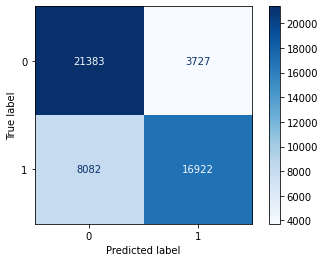

In [193]:
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(forest, X, y, display_labels = ['0','1'], cmap=plt.cm.Blues, values_format = "d")
plt.plot(cmap=plt.cm.Blues)
plt.savefig('fig.eps')
files.download("fig.eps")